In [1]:
#加载模型，导入与数据处理相关的库并检查版本
# https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/
!pip install graphviz
import sys 
print("Python version: {}". format(sys.version))

import pandas as pd 
print("pandas version: {}". format(pd.__version__))

import matplotlib 
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np 
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display 
print("IPython version: {}". format(IPython.__version__)) 

import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

import random
import time

#忽略警告
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

# 输入数据文件在 "./data/input/" 目录中.
from subprocess import check_output
print(check_output(["ls", "./data/input"]).decode("utf8"))

Python version: 3.8.6 | packaged by conda-forge | (default, Nov 27 2020, 19:00:52) 
[GCC 9.3.0]
pandas version: 1.2.0
matplotlib version: 3.3.3
NumPy version: 1.19.4
SciPy version: 1.5.3
IPython version: 7.19.0
scikit-learn version: 0.24.0
-------------------------
gender_submission.csv
test.csv
train.csv



In [2]:
#导入与建模预测相关的库
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#配置可视化相关模块
#%matplotlib inline 在Jupyter Notebook 浏览器中显示plot
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [3]:
#数据读取与检查part
#导入数据集并做一个概览

data_raw = pd.read_csv('./data/input/train.csv')

data_val  = pd.read_csv('./data/input/test.csv')

#create a copy
data1 = data_raw.copy(deep = True)

data_cleaner = [data1, data_val]


#预览数据集
print (data_raw.info()) 
data_raw.sample(10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
779,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,NaN,S
295,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,27.7208,NaN,C
646,647,0,3,"Cor, Mr. Liudevit",male,19.0,0,0,349231,7.8958,NaN,S
570,571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S
388,389,0,3,"Sadlier, Mr. Matthew",male,NaN,0,0,367655,7.7292,NaN,Q
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S
189,190,0,3,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S


In [4]:
data_raw[data_raw['Sex']=='male']['Survived'].mean()

0.18890814558058924

数据清洗4C原则
1. 校正(Correcting)
2. 填充(Completing)
3. 创建(Creating)
4. 转换(Converting)

In [5]:
# Correcting 检查数据是否有异常值（超出范围或缺失）

print('Train columns with null values:\n', data1.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-"*10)

data_raw.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Butler, Mr. Reginald Fenton",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
# Completing 对有缺失值的样本删除或填充

#对缺失值进行处理
for dataset in data_cleaner:    
    
    #使用中位数填充缺失值
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Cabin'].mode(0), inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#删除部分数据，对结果不具备太大价值的列
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace = True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [7]:
# Creating 特征工程，手动增加特征
#Feature Engineering for train and test/validation dataset

for dataset in data_cleaner:    
    #离散变量
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 

    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    #Fare Bins/Buckets using qcut or frequency bins
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

    
#cleanup rare title names
stat_min = 10 
title_names = (data1['Title'].value_counts() < stat_min) 

data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*10)


#重新预览数据集
data1.info()
data_val.info()
data1.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    889 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.9+ KB
<class 'pandas.core.frame.DataFrame'>
Ra

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
402,0,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,9.8250,S,2,0,Miss,"(7.91, 14.454]","(16.0, 32.0]"
138,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,9.2167,S,1,1,Mr,"(7.91, 14.454]","(-0.08, 16.0]"
833,0,3,"Augustsson, Mr. Albert",male,23.0,0,0,7.8542,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
455,1,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,7.8958,C,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
190,1,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,13.0000,S,1,1,Mrs,"(7.91, 14.454]","(16.0, 32.0]"
335,0,3,"Denkoff, Mr. Mitto",male,28.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
150,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,12.5250,S,1,1,Misc,"(7.91, 14.454]","(48.0, 64.0]"
126,0,3,"McMahon, Mr. Martin",male,28.0,0,0,7.7500,Q,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
785,0,3,"Harmer, Mr. Abraham (David Lishin)",male,25.0,0,0,7.2500,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
58,1,2,"West, Miss. Constance Mirium",female,5.0,1,2,27.7500,S,4,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]"


In [8]:
#Converting: 使用Label Encoder 将数据中表示类别的字符串转换成类别标记

label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')

#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')



data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [9]:
#再次检查数据

print('Train columns with null values: \n', data1.isnull().sum())
print("-"*10)
print (data1.info())
print("-"*10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-"*10)
print (data_val.info())
print("-"*10)

data_raw.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         2
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked       889 no

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Butler, Mr. Reginald Fenton",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [10]:
#划分训练集与测试集
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


In [11]:
Target

['Survived']

In [12]:
#探索性分析part

#Discrete Variable Correlation by Survival using
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        
print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

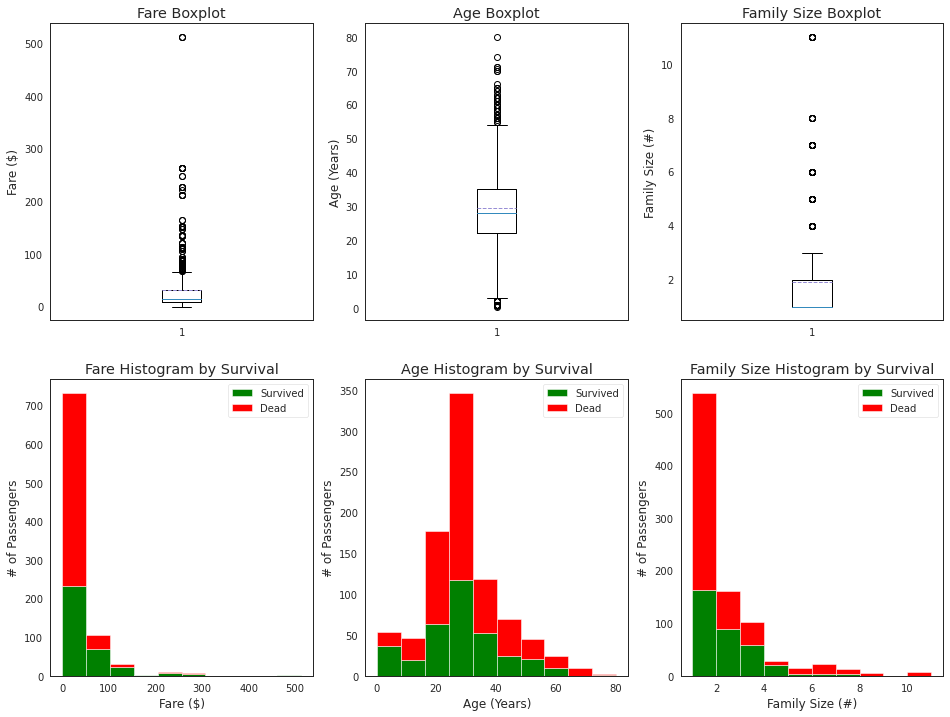

In [13]:
#通过可视化显示分析结果
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

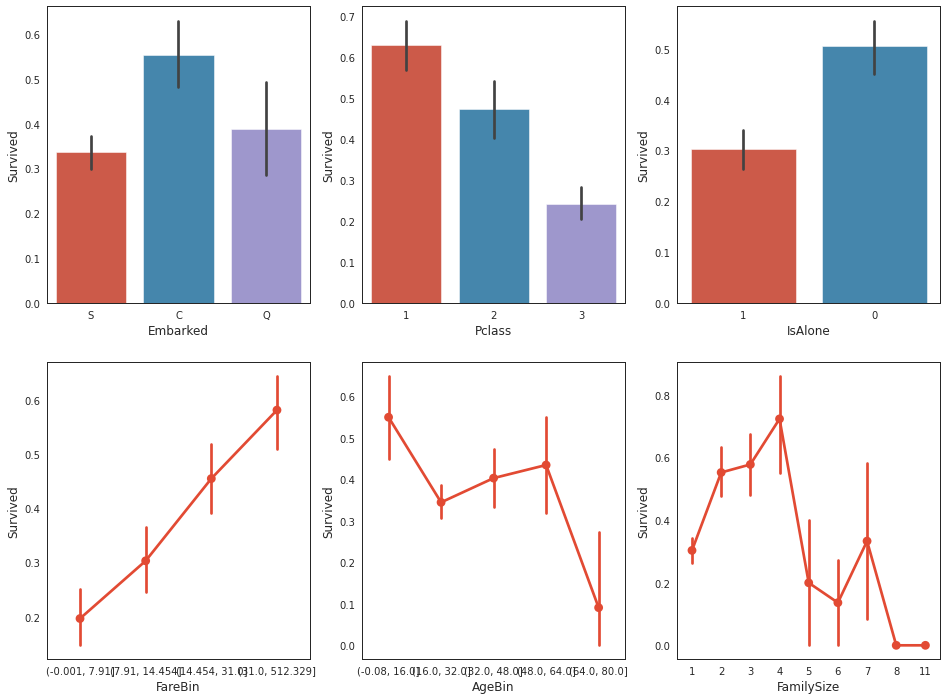

In [14]:
#使用seaborn graphics

fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparison')

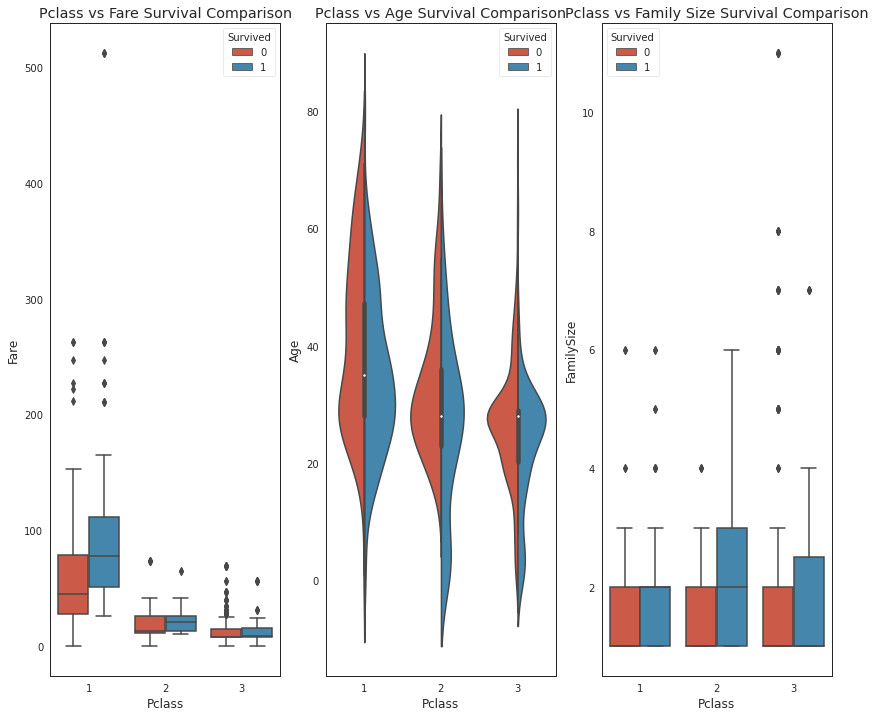

In [15]:
#探索性分析part
#graph distribution of qualitative data: Pclass

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = data1, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

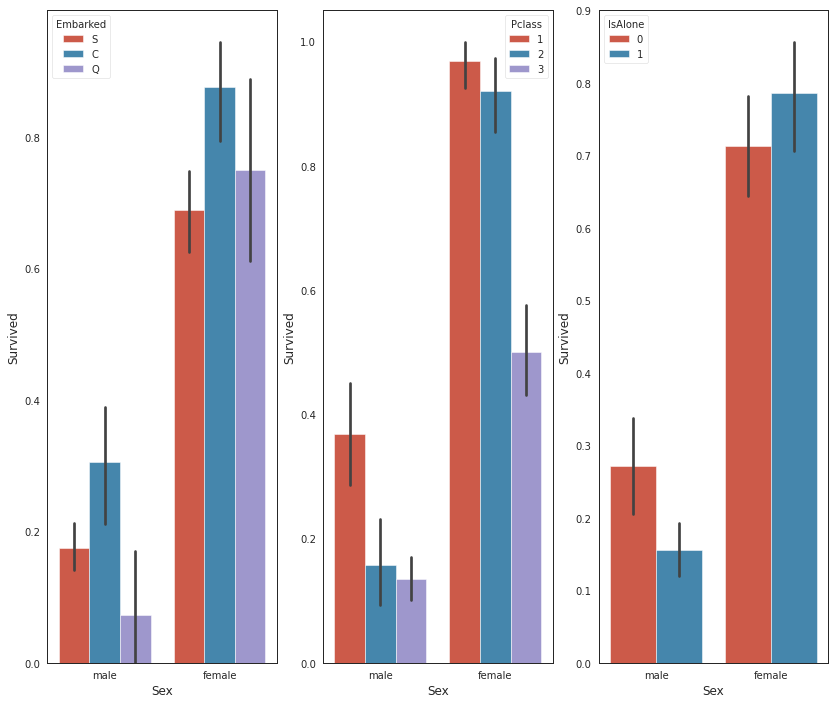

In [16]:
#探索性分析part
#graph distribution of qualitative data: Sex
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

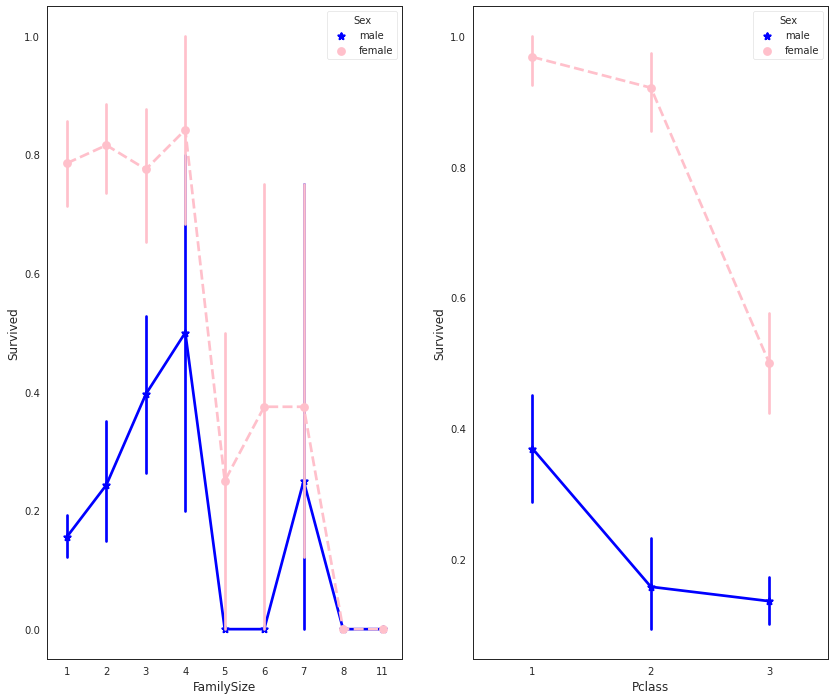

In [17]:
#探索性分析part
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

#family size factor with sex & survival compare
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)


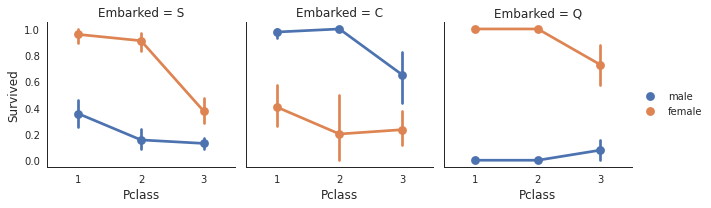

In [18]:
#探索性分析part
#embark port factor with class, sex, and survival compare

e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

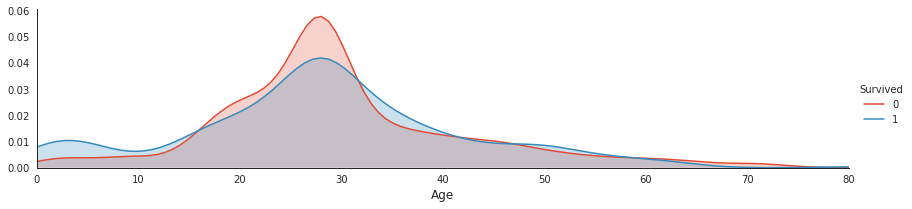

In [19]:
#探索性分析part
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( data1, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , data1['Age'].max()))
a.add_legend()

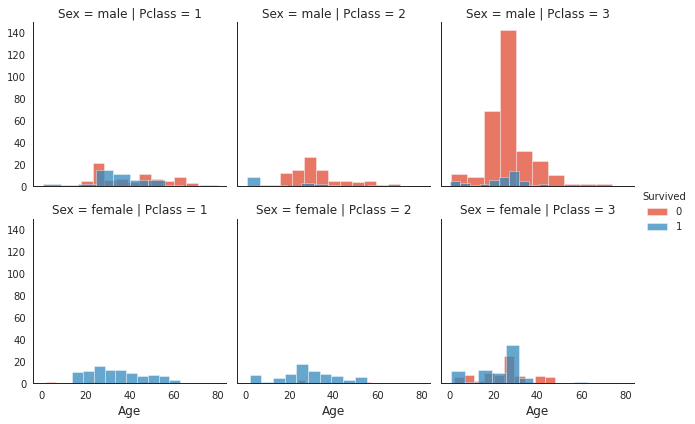

In [20]:
#探索性分析part
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

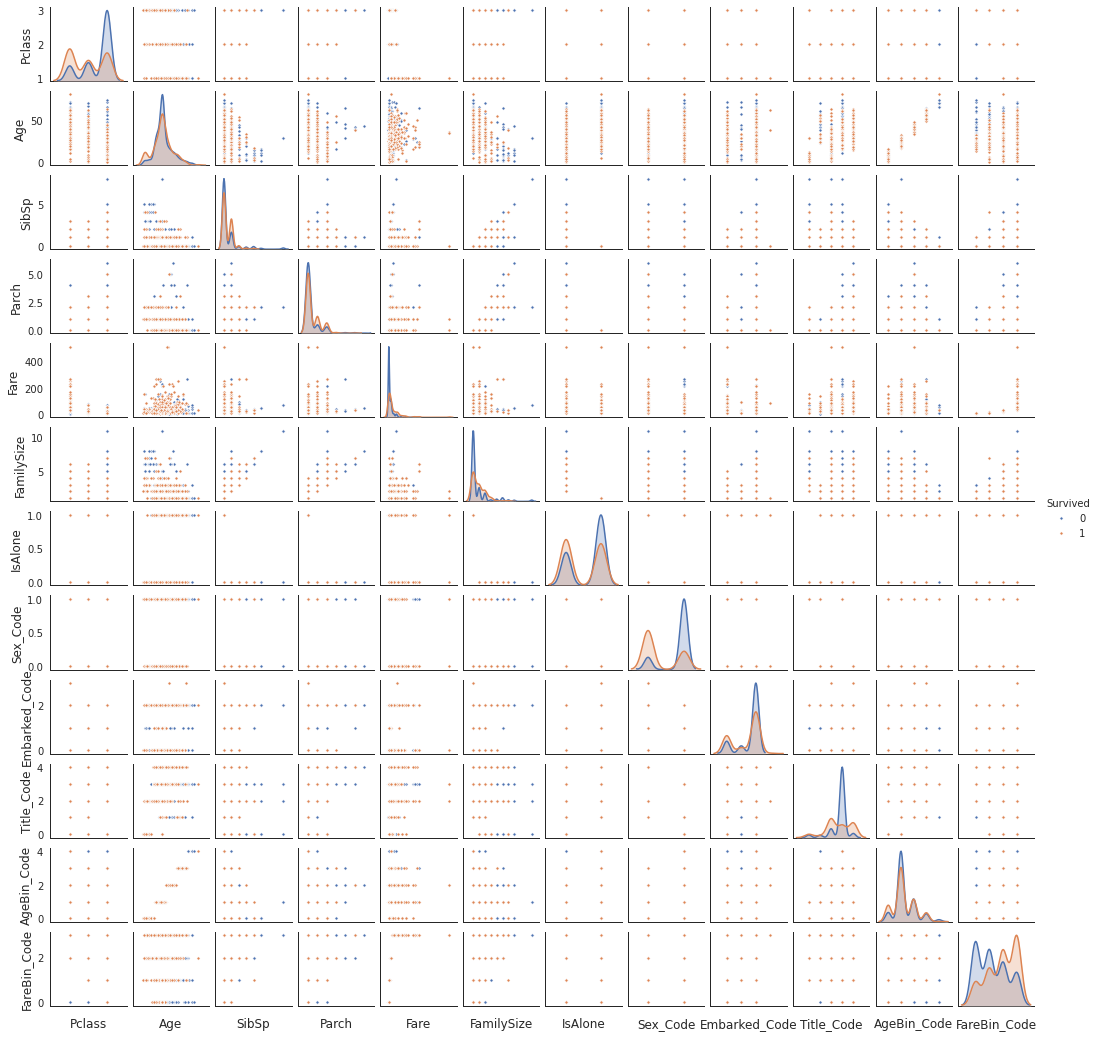

In [21]:
#探索性分析part
#pair plots of entire dataset
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

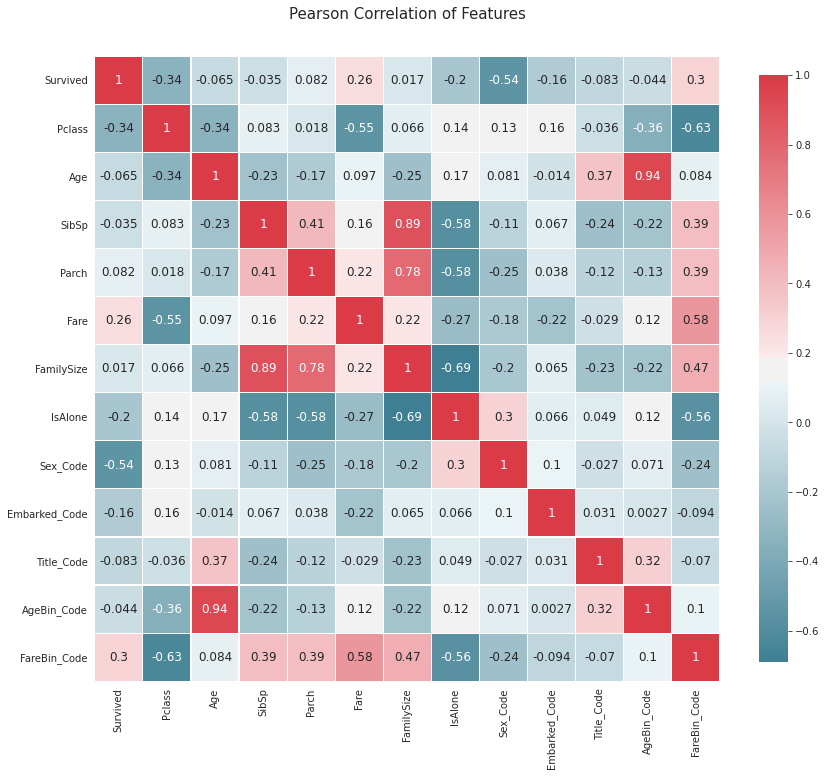

In [22]:
#探索性分析part
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

In [23]:
#建模分析part
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    cv_results = model_selection.cross_validate( alg, data1[data1_x_bin],data1[Target], cv=cv_split, return_train_score=True )
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

[13:27:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.835019,0.827985,0.040808,0.055018
21,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.890449,0.826493,0.061770,1.919227
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.834270,0.826119,0.045663,0.064853
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.889700,0.825373,0.050757,0.029233
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.895131,0.822015,0.058606,0.151143
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.865918,0.822015,0.052992,0.094261
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.895131,0.820896,0.061312,0.199179
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.819403,0.056682,0.005337
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.849251,0.814925,0.060737,0.005162
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.811194,0.065693,0.005187


Text(0, 0.5, 'Algorithm')

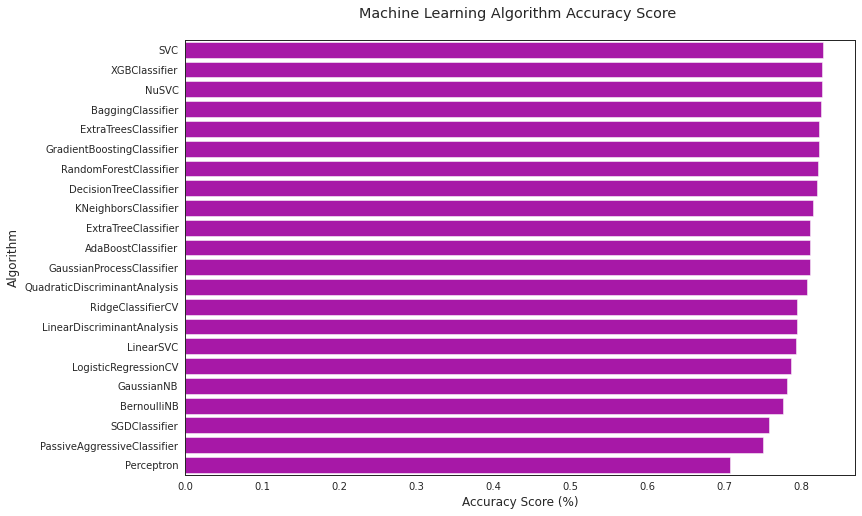

In [24]:
#建模分析part
#barplot 
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [25]:
#模型评估part

#coin flip model with random 1/survived 0/died

#iterate over dataFrame rows as (index, Series) pairs
for index, row in data1.iterrows(): 
    #random number generator
    if random.random() > .5:     
        #data1.set_value(index, 'Random_Predict', 1) #predict survived/1
        data1.at[index, 'Random_Predict']= 1
    else: 
        #data1.set_value(index, 'Random_Predict', 0) #predict died/0
        data1.at[index, 'Random_Predict']= 0
    

#score random guess of survival. Use shortcut 1 = Right Guess and 0 = Wrong Guess

data1['Random_Score'] = 0 #assume prediction wrong
data1.loc[(data1['Survived'] == data1['Random_Predict']), 'Random_Score'] = 1 
print('Coin Flip Model Accuracy: {:.2f}%'.format(data1['Random_Score'].mean()*100))

print('Coin Flip Model Accuracy w/SciKit: {:.2f}%'.format(metrics.accuracy_score(data1['Survived'], data1['Random_Predict'])*100))

Coin Flip Model Accuracy: 49.83%
Coin Flip Model Accuracy w/SciKit: 49.83%


In [26]:
#模型评估part
#group by or pivot table
pivot_female = data1[data1.Sex=='female'].groupby(['Sex','Pclass', 'Embarked','FareBin'])['Survived'].mean()
print('Survival Decision Tree w/Female Node: \n',pivot_female)

pivot_male = data1[data1.Sex=='male'].groupby(['Sex','Title'])['Survived'].mean()
print('\n\nSurvival Decision Tree w/Male Node: \n',pivot_male)

Survival Decision Tree w/Female Node: 
 Sex     Pclass  Embarked  FareBin        
female  1       C         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]          NaN
                          (31.0, 512.329]    1.000000
                S         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.953488
        2       C         (-0.001, 7.91]          NaN
                          (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (-0.001, 7.91]          NaN


In [27]:
#模型评估part
#决策树
def mytree(df):
    
    #initialize table to store predictions
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master'] 

    for index, row in df.iterrows():

        #Question 1: Were you on the Titanic; majority died
        Model.loc[index, 'Predict'] = 0

        #Question 2: Are you female; majority survived
        if (df.loc[index, 'Sex'] == 'female'):
                  Model.loc[index, 'Predict'] = 1

        #Question 3A Female - Class and Question 4 Embarked gain minimum information

        #Question 5B Female - FareBin; set anything less than .5 in female node decision tree back to 0       
        if ((df.loc[index, 'Sex'] == 'female') & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 'S')  &
            (df.loc[index, 'Fare'] > 8)

           ):
                  Model.loc[index, 'Predict'] = 0

        #Question 3B Male: Title; set anything greater than .5 to 1 for majority survived
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Title'] in male_title)
            ):
            Model.loc[index, 'Predict'] = 1
        
        
    return Model


#model data
Tree_Predict = mytree(data1)
print('Decision Tree Model Accuracy/Precision Score: {:.2f}%\n'.format(metrics.accuracy_score(data1['Survived'], Tree_Predict)*100))

print(metrics.classification_report(data1['Survived'], Tree_Predict))

Decision Tree Model Accuracy/Precision Score: 82.04%

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       549
           1       0.82      0.68      0.75       342

    accuracy                           0.82       891
   macro avg       0.82      0.79      0.80       891
weighted avg       0.82      0.82      0.82       891



Confusion matrix, without normalization
[[497  52]
 [108 234]]
Normalized confusion matrix
[[0.91 0.09]
 [0.32 0.68]]


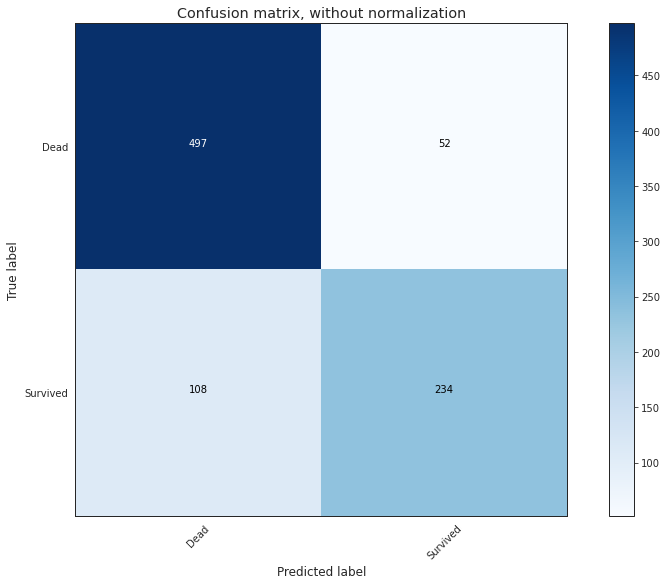

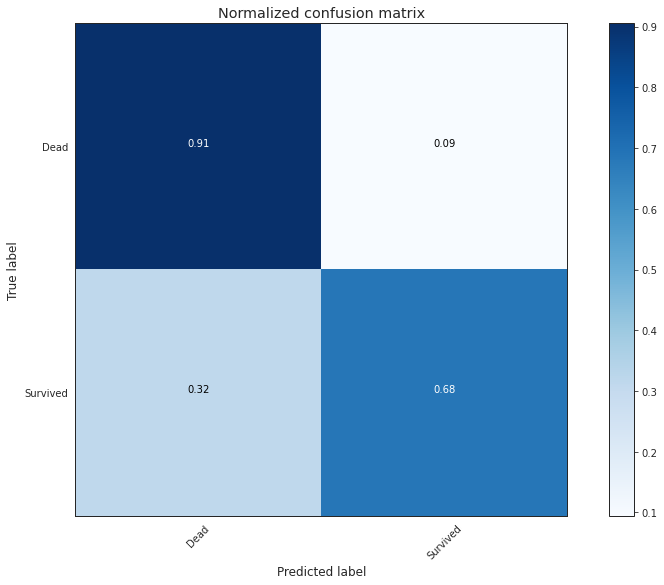

In [28]:
#Plot Accuracy Summary
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = metrics.confusion_matrix(data1['Survived'], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [29]:
#参数调整part
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv  = cv_split,return_train_score=True )
dtree.fit(data1[data1_x_bin], data1[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; 
              
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; 
              'random_state': [0] #seed or control random number generator
             }


#choose best model with grid_search
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split,return_train_score=True)
tune_model.fit(data1[data1_x_bin], data1[Target])

print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)


BEFORE DT Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.13
BEFORE DT Test w/bin score 3*std: +/- 5.78
----------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.35
AFTER DT Test w/bin score mean: 87.41
AFTER DT Test w/bin score 3*std: +/- 5.07
----------


In [30]:
#特征选择part
#base model
print('BEFORE DT RFE Training Shape Old: ', data1[data1_x_bin].shape) 
print('BEFORE DT RFE Training Columns Old: ', data1[data1_x_bin].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

#transform x&y to reduced features and fit new model
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv  = cv_split,return_train_score=True)

print('AFTER DT RFE Training Shape New: ', data1[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split,return_train_score=True)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
BEFORE DT RFE Training w/bin score mean: 89.51
BEFORE DT RFE Test w/bin score mean: 82.13
BEFORE DT RFE Test w/bin score 3*std: +/- 5.78
----------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
AFTER DT RFE Training w/bin score mean: 88.16
AFTER DT RFE Test w/bin score mean: 83.06
AFTER DT RFE Test w/bin score 3*std: +/- 6.22
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.39
AFTER DT RFE Tuned Test w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.21
----------


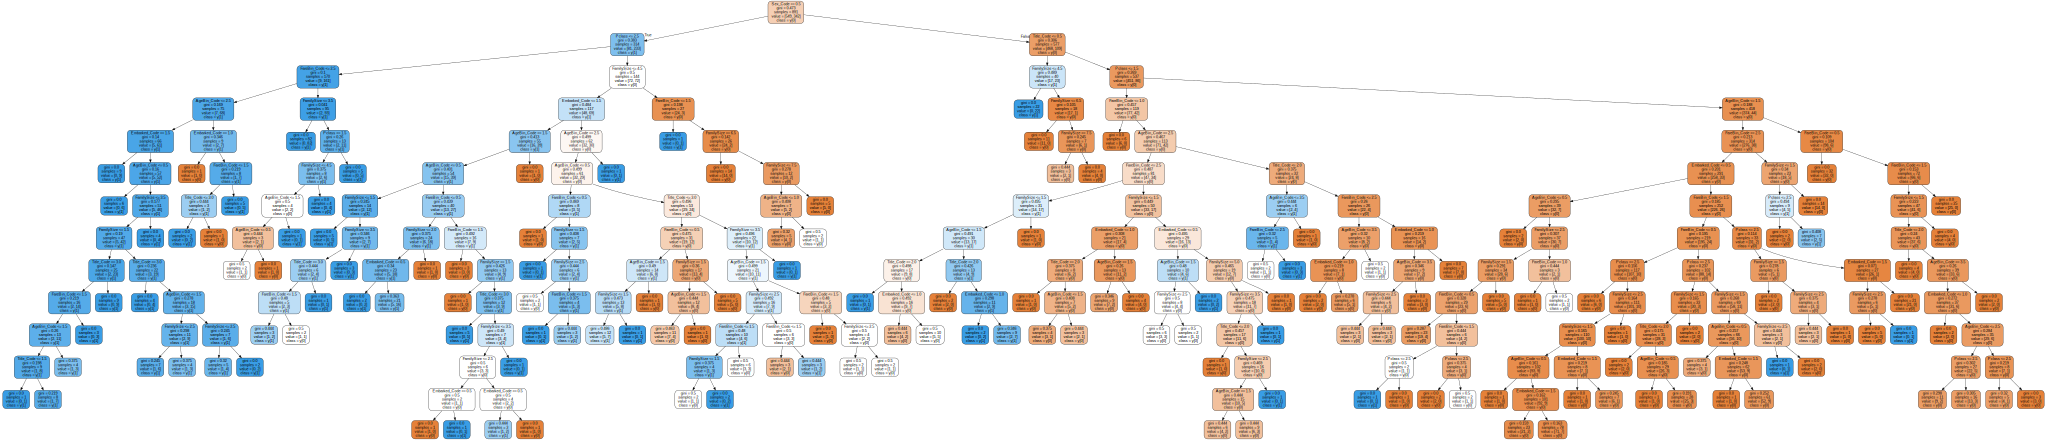

In [31]:
#Graph MLA version of Decision Tree
import graphviz 
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names = data1_x_bin, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 
graph

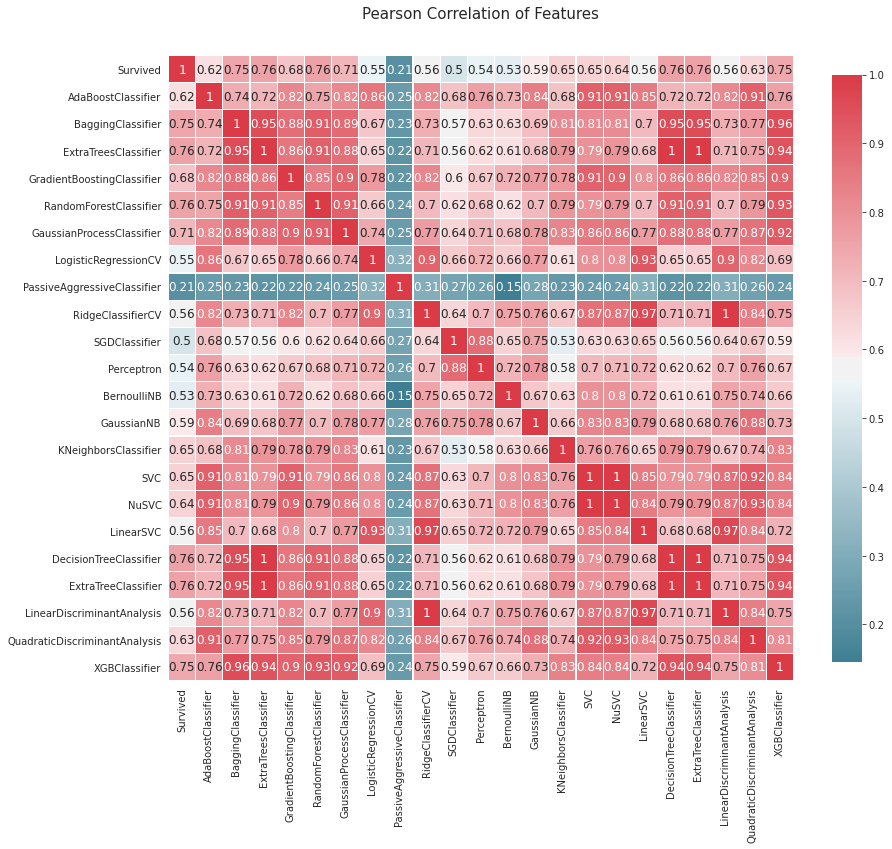

In [32]:
#模型验证与实施part
correlation_heatmap(MLA_predict)

In [33]:
#模型验证与实施part
vote_est = [
    #Ensemble Methods
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: 
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies 
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM
    ('svc', svm.SVC(probability=True)),
    
    #xgboost
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target], cv  = cv_split,return_train_score=True)
vote_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv  = cv_split,return_train_score=True)
vote_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

[13:27:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
#模型验证与实施part

#Hyperparameter Tune with GridSearchCV
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier 
            'n_estimators': grid_n_estimator, 
            'learning_rate': grid_learn, 
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier 
            'n_estimators': grid_n_estimator, 
            'max_samples': grid_ratio, 
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier 
            'n_estimators': grid_n_estimator, 
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier 
            'learning_rate': [.05], 
            'n_estimators': [300], 
            'max_depth': grid_max_depth, 
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier 
            'n_estimators': grid_n_estimator, 
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'oob_score': [True], 
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, 
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV 
            'fit_intercept': grid_bool, 
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB 
            'alpha': grid_ratio, 
             }],
    
    
            #GaussianNB 
            [{}],
    
            [{
            #KNeighborsClassifier 
            'n_neighbors': [1,2,3,4,5,6,7], 
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC 
            'C': [1,2,3,4,5], 
            'gamma': grid_ratio, 
            'decision_function_shape': ['ovo', 'ovr'], 
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier 
            'learning_rate': grid_learn, 
            'max_depth': [1,2,4,6,8,10], 
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() 
for clf, param in zip (vote_est, grid_param): 
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(data1[data1_x_bin], data1[Target])
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

In [ ]:
#模型验证与实施part
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, data1[data1_x_bin], data1[Target], cv  = cv_split,return_train_score=True)
grid_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, data1[data1_x_bin], data1[Target], cv  = cv_split,return_train_score=True)
grid_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)


In [ ]:
#模型验证与实施part
#prepare data for modeling
print(data_val.info())
print("-"*10)

#handmade decision tree - submission score = 0.77990
data_val['Survived'] = mytree(data_val).astype(int)


#decision tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_dt = tree.DecisionTreeClassifier()
#submit_dt = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
#submit_dt.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_dt.best_params_) #Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
#data_val['Survived'] = submit_dt.predict(data_val[data1_x_bin])


#bagging w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77990
#submit_bc = ensemble.BaggingClassifier()
#submit_bc = model_selection.GridSearchCV(ensemble.BaggingClassifier(), param_grid= {'n_estimators':grid_n_estimator, 'max_samples': grid_ratio, 'oob_score': grid_bool, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_bc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_bc.best_params_) #Best Parameters:  {'max_samples': 0.25, 'n_estimators': 500, 'oob_score': True, 'random_state': 0}
#data_val['Survived'] = submit_bc.predict(data_val[data1_x_bin])


#extra tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_etc = ensemble.ExtraTreesClassifier()
#submit_etc = model_selection.GridSearchCV(ensemble.ExtraTreesClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_etc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_etc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_etc.predict(data_val[data1_x_bin])


#random foreset w/full dataset modeling submission score: defaults= 0.71291, tuned= 0.73205
#submit_rfc = ensemble.RandomForestClassifier()
#submit_rfc = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_rfc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_rfc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_rfc.predict(data_val[data1_x_bin])



#ada boosting w/full dataset modeling submission score: defaults= 0.74162, tuned= 0.75119
#submit_abc = ensemble.AdaBoostClassifier()
#submit_abc = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), param_grid={'n_estimators': grid_n_estimator, 'learning_rate': grid_ratio, 'algorithm': ['SAMME', 'SAMME.R'], 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_abc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_abc.best_params_) #Best Parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0}
#data_val['Survived'] = submit_abc.predict(data_val[data1_x_bin])


#gradient boosting w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77033
#submit_gbc = ensemble.GradientBoostingClassifier()
#submit_gbc = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid={'learning_rate': grid_ratio, 'n_estimators': grid_n_estimator, 'max_depth': grid_max_depth, 'random_state':grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_gbc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_gbc.best_params_) #Best Parameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 50, 'random_state': 0}
#data_val['Survived'] = submit_gbc.predict(data_val[data1_x_bin])

#extreme boosting w/full dataset modeling submission score: defaults= 0.73684, tuned= 0.77990
#submit_xgb = XGBClassifier()
#submit_xgb = model_selection.GridSearchCV(XGBClassifier(), param_grid= {'learning_rate': grid_learn, 'max_depth': [0,2,4,6,8,10], 'n_estimators': grid_n_estimator, 'seed': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_xgb.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_xgb.best_params_) #Best Parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0}
#data_val['Survived'] = submit_xgb.predict(data_val[data1_x_bin])


#hard voting classifier w/full dataset modeling submission score: defaults= 0.75598, tuned = 0.77990
#data_val['Survived'] = vote_hard.predict(data_val[data1_x_bin])
data_val['Survived'] = grid_hard.predict(data_val[data1_x_bin])


#soft voting classifier w/full dataset modeling submission score: defaults= 0.73684, tuned = 0.74162
#data_val['Survived'] = vote_soft.predict(data_val[data1_x_bin])
#data_val['Survived'] = grid_soft.predict(data_val[data1_x_bin])


#submit file
submit = data_val[['PassengerId','Survived']]
submit.to_csv("./data/working/submit.csv", index=False)

print('Validation Data Distribution: \n', data_val['Survived'].value_counts(normalize = True))
submit.sample(10)